In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from interpolating_match import *
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [108]:
def SNR2ecc(matches, chirp, interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0):
    """
    Maps SNR samples to eccentricity samples.

    Parameters:
        matches: SNR samples.
        chirp: Chirp mass at zero eccentricity.
        interps: Interpolation objects used to interpolate to the min/max lines of the desired chirp mass.
        max_ecc: Maximum value of eccentricity.
        scaling_norms: Non-eccentric chirp mass and fiducial eccentricity used 
        to normalise relationship.
        upper_lenience: Allow upper bound of eccentricity samples to be higher than max_ecc.

    Returns:
        eccs: Eccentricity samples.
    """

    # Find upper and lower bounds on eccentricity for each sample
    ecc_arr = find_ecc_range_samples(matches, chirp, interps, max_ecc=max_ecc, scaling_norms=scaling_norms)

    # Put upper bound at max_ecc
    max_ecc *= 1+upper_lenience
    inds = ecc_arr>max_ecc
    ecc_arr[inds] = max_ecc

    # Uniformly draw random value between these bounds for each sample
    eccs = np.random.rand(len(matches))*(ecc_arr[1]-ecc_arr[0]) + ecc_arr[0]

    return eccs

Taking a uniform distribution in SNR (ratio) and mapping to samples of eccentricity we find the following distribution:

In [2]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_48', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
    
# Find min and max
for chirp in grid_data.keys():
    for key in list(grid_data[chirp].keys()):
        if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
            grid_data[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data[chirp][key]), axis=1)
            grid_data[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data[chirp][key]), axis=1)

# Compute interpolation objects
interp_dict = {}
for key in ['h1_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pc']:
    interp_dict[key] = create_min_max_interp(grid_data, list(grid_data.keys())[1], key)

/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:280: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[0][ecc_arr[0]==5] = max_interp(matches[ecc_arr[0]==5])
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:281: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[1][ecc_arr[1]==5] = min_interp(matches[ecc_arr[1]==5])


Text(0.5, 0, '$e_{10}$')

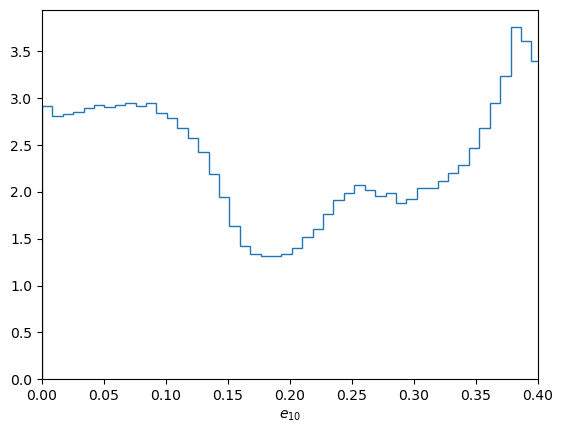

In [3]:
match_key = 'h1_h-1_h0_pc'
interps = interp_dict[match_key]
match_samples = np.linspace(0, 0.4, 10**6)
ecc_samples = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples, histtype='step', bins=50, density=True)
plt.xlim(0, 0.4)
plt.xlabel('$e_{10}$')

In order to enforce a flat eccentricity prior we must find a prior on the SNR samples that gives a flat distribution above. We can do this by mapping a flat eccentricity distribution 'in reverse' back to an SNR distribution. This can then be combined with the SNR distribution found by rejection sampling the ncx2 distrbution to find the overall SNR distribution which we can map through to get the final eccentricity distribution. This will remove the bimodal features we often see and will therefore hopefully end up with a much smoother gaussian-like structure.

First step is to reverse the mapping such that we can map samples on eccentricity to samples on SNR. Forward mapping works by drawing ecc value uniformly between min and max lines, so this reverse mapping should reflect this as well.

Will first go over all possible SNR values and find width of min/max lines at each point. Can then use inverse of these widths as weights for rejection sampling samples chosen uniformly between min and max lines at a given ecc value.

In [4]:
def ecc2SNR_rej(eccs, chirp, interps, max_ecc=0.4, scaling_norms=[10, 0.035]):

    # Build 'inverse widths' for each SNR trial value
    SNR_trials = np.linspace(0, 1, 10**4)
    ecc_bounds = find_ecc_range_samples(SNR_trials, chirp, interps, max_ecc=max_ecc, scaling_norms=scaling_norms)
    iwidth_arr = 1/(ecc_bounds[1]-ecc_bounds[0])
    iwidth_interp = interp1d(SNR_trials, iwidth_arr)

    # Find max inverse width for each eccentricity
    upper_SNR = np.real(interps[0](eccs))
    lower_SNR = np.real(interps[1](eccs))
    upper_SNR[eccs>max_ecc] = 1
    lower_SNR[eccs>max_ecc] = np.real(interps[1](max_ecc))
    max_iwidths = []
    for i in range(len(eccs)):
        inds = np.asarray(np.logical_and(SNR_trials >= lower_SNR[i], SNR_trials <= upper_SNR[i])).nonzero()
        max_iwidths.append(np.max(iwidth_arr[inds]))
    max_iwidths = np.array(max_iwidths)
    
    # Draw SNR samples for each eccentricity using rejection sampling
    need_sample = np.full(len(eccs), True)
    SNR_samples = []
    count=0
    while True in need_sample:
        SNR_proposals = np.random.uniform(size=np.sum(need_sample))*(upper_SNR[need_sample]-lower_SNR[need_sample])+lower_SNR[need_sample]
        accepts = np.random.uniform(size=np.sum(need_sample))
        weights = iwidth_interp(SNR_proposals)/max_iwidths[need_sample]
        SNR_samples += list(SNR_proposals[weights>=accepts])
        need_sample[need_sample] = weights<accepts
        count+=1
        if count%1000==0:
            print(np.sum(need_sample))
    print(f'{count} loops')
        
    return SNR_samples

Let's try mapping a flat distribution on eccentricity to SNR and back and see if we recover a flat distribution again.

In [5]:
ecc_samples = np.linspace(0, 0.6, 10**6)
match_samples = ecc2SNR_rej(ecc_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035])
ecc_samples2 = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)

108 loops


(0.0, 0.4)

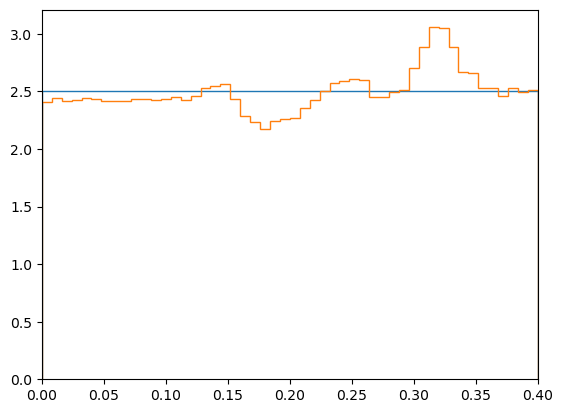

In [6]:
plt.hist(ecc_samples[ecc_samples<=0.4], histtype='step', bins=50, density=True)
plt.hist(ecc_samples2[ecc_samples2<=0.4], histtype='step', bins=50, density=True)
plt.xlim(0,0.4)

We see there is still some structure in similar-ish locations to when using a flat prior on SNR. Believe this comes from the fact that the rejection sampling implictly assumes a flat prior on SNR which we know to not be the case.

Let's see for curiosity what the 'double mapped' distribution looks like if we forgo rejection sampling and simply draw uniformly between a min and max SNR value for each eccentricity value.

In [7]:
def ecc2SNR(eccs, interps, max_ecc=0.4, max_match=1):

    upper_SNR = np.real(interps[0](eccs))
    lower_SNR = np.real(interps[1](eccs))
    upper_SNR[eccs>max_ecc] = max_match
    lower_SNR[eccs>max_ecc] = np.real(interps[1](max_ecc))
    SNR_samples = np.random.uniform(size=len(eccs))*(upper_SNR-lower_SNR)+lower_SNR
        
    return SNR_samples

In [8]:
ecc_samples = np.linspace(0, 0.49, 10**6)
match_samples = ecc2SNR(ecc_samples, interps, max_ecc=0.4)
ecc_samples2 = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)

(0.0, 0.4)

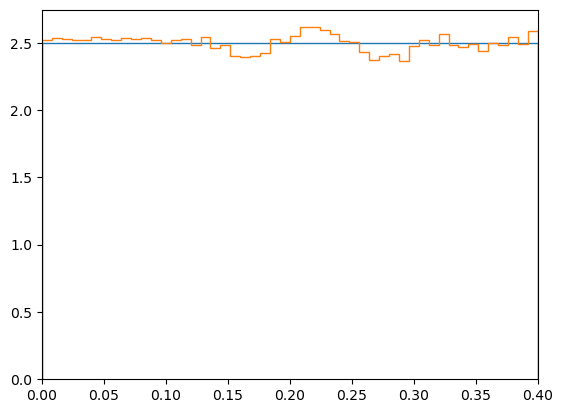

In [9]:
plt.hist(ecc_samples[ecc_samples<=0.4], histtype='step', bins=50, density=True)
plt.hist(ecc_samples2[ecc_samples2<=0.4], histtype='step', bins=50, density=True)
plt.xlim(0,0.4)

This is better but there is still structure consistent against repeated runs arising from the fact that this reverse mapping is not exactly equivalent to the forward mapping.

So in order to perform the 'correct' rejection sampling we must know the prior of the SNR distribution in order to calculate the prior of the SNR distribution - obviously circular.

Let's try flipping the mapping methods here by drawing uniformly between min and max SNR value for each eccentricity sample, and use rejection sampling for the 'forward mapping' from SNR to eccentricity. Here we can freely use a flat prior on eccentricity by definition.

In [10]:
def SNR2ecc_rej(matches, chirp, interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0, max_match=1):

    # Put upper bound at max_ecc (with some lenience to allow for higher bins when railing)
    lenient_max_ecc = max_ecc*(1+upper_lenience)

    # Build 'inverse widths' for each ecc trial value
    ecc_trials = np.linspace(0, lenient_max_ecc, 10**3)
    SNR_maxs = np.real(interps[0](ecc_trials))
    SNR_mins = np.real(interps[1](ecc_trials))
    SNR_maxs[ecc_trials>max_ecc] = max_match
    SNR_mins[ecc_trials>max_ecc] = np.real(interps[1](max_ecc))
    iwidth_arr = 1/(SNR_maxs-SNR_mins)
    iwidth_interp = interp1d(ecc_trials, iwidth_arr)

    # Find max inverse width for each SNR
    ecc_bounds = find_ecc_range_samples(matches, chirp, interps, max_ecc=max_ecc, scaling_norms=scaling_norms)
    max_iwidths = []
    for i in range(len(matches)):
        inds = np.asarray(np.logical_and(ecc_trials >= ecc_bounds[0][i], ecc_trials <= ecc_bounds[1][i])).nonzero()
        max_iwidths.append(np.max(iwidth_arr[inds]))
    max_iwidths = np.array(max_iwidths)
    inds = ecc_bounds>lenient_max_ecc
    ecc_bounds[inds] = lenient_max_ecc

    # Draw ecc samples for each SNR using rejection sampling
    need_sample = np.full(len(matches), True)
    ecc_samples = []
    count=0
    while True in need_sample:
        ecc_proposals = np.random.uniform(size=np.sum(need_sample))*(ecc_bounds[1][need_sample]-ecc_bounds[0][need_sample])+ecc_bounds[0][need_sample]
        accepts = np.random.uniform(size=np.sum(need_sample))
        weights = iwidth_interp(ecc_proposals)/max_iwidths[need_sample]
        ecc_samples += list(ecc_proposals[weights>=accepts])
        need_sample[need_sample] = weights<accepts
        count+=1
        if count%1000==0:
            print(np.sum(need_sample))
    print(f'{count} loops')

    return np.array(ecc_samples)

In [11]:
ecc_samples = np.linspace(0, 0.4*1.05, 10**6)
match_samples = ecc2SNR(ecc_samples, interps, max_ecc=0.4)
ecc_samples2 = SNR2ecc_rej(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)

25 loops


(0.0, 0.44100000000000006)

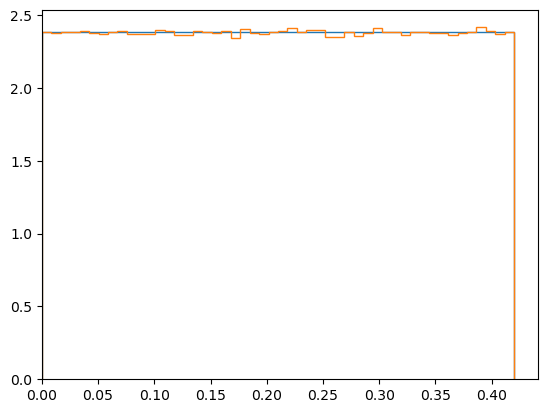

In [12]:
plt.hist(ecc_samples, histtype='step', bins=50, density=True)
plt.hist(ecc_samples2, histtype='step', bins=50, density=True)
plt.xlim(0,)

Not only does this work extremely well but it has also solved another problem of where to put the upper bound of the prior - before it had to be some seemingly arbitrary number to make the upper end of the double mapped distribution flat. Now we simple use the lenient max eccentricity which makes more sense and does not need to be calculated.

Let's finally have a look at the resulting prior on match samples this has given us.

(0.0, 1.0498974831014993)

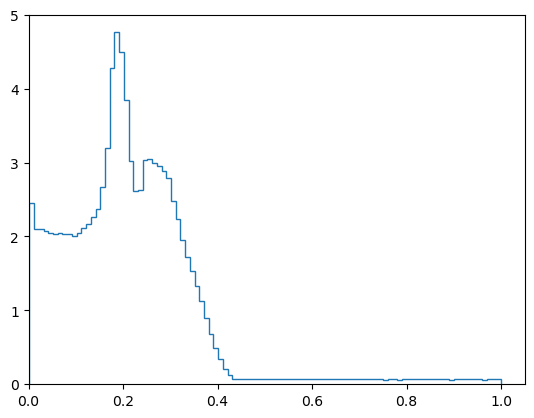

In [13]:
plt.hist(match_samples, histtype='step', bins=100, density=True)
plt.xlim(0,)

This looks a little odd but clearly works.

The next step is now to work out how to multiply this prior distribution with the 'likelihood' given by rejection sampling the ncx2 distribution. If we had an analytical form of one of these distributions then we could do this simply with (yet more) rejection sampling, however we have both as collections of samplings. Our likelihood distribution is however very smooth and so we could represent it as a kde, and thus perform rejection sampling.

Trying this here:

(0.0, 1.0)

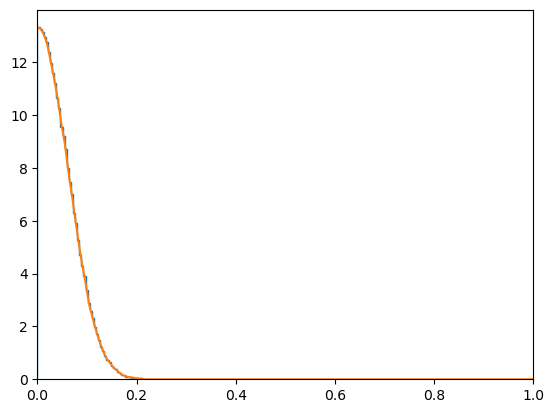

In [14]:
ncx2_samples = SNR_samples(1, 3, 3*10**5)/20
ncx2_builders = list(ncx2_samples) + list(-ncx2_samples)
kde_factor = 0.5*len(ncx2_samples)**(-1./5)
ncx2_kde = gaussian_kde(ncx2_builders, bw_method=kde_factor)
match_ratio = np.linspace(0, 1, 10**3)
match_pdf = ncx2_kde.pdf(match_ratio)*2
plt.hist(ncx2_samples, histtype='step', bins=50, density=True)
plt.plot(match_ratio, match_pdf)
plt.xlim(0,1)

The kde approximation seems to fit very well. We build the kde from a mirrored distribution about zero in order to accurately capture the behaviour close to zero. We must then double the pdf values in order to keep the area under the positive part of the curve equal to one (not important for rejection sampling below as just a scaling to weights).

In [15]:
def comb_match_prior(ncx2_samples, prior_samples, kde_prefactor=0.5):

    # Create kde on ncx2 distribution
    ncx2_builders = list(ncx2_samples) + list(-ncx2_samples)
    kde_factor = kde_prefactor*len(ncx2_samples)**(-1./5)
    ncx2_kde = gaussian_kde(ncx2_builders, bw_method=kde_factor)

    # Generate weights
    prior_range = np.linspace(np.min(prior_samples), np.max(prior_samples), 10**3)
    sparse_weights = ncx2_kde.pdf(prior_range)
    weight_interp = interp1d(prior_range, sparse_weights)
    weights = weight_interp(prior_samples)
    weights /= np.max(weights)

    # Perform rejection sampling
    accepts = np.random.uniform(size=len(prior_samples))
    match_samples = prior_samples[weights>=accepts]

    return match_samples

In [102]:
ncx2_samples = SNR_samples(4.11, 3, 3*10**5)/21.13
ecc_prior = np.linspace(0, 0.4*1.05, 10**6)
match_prior = ecc2SNR(ecc_prior, interps, max_ecc=0.4)
match_samples = comb_match_prior(ncx2_samples, match_prior)

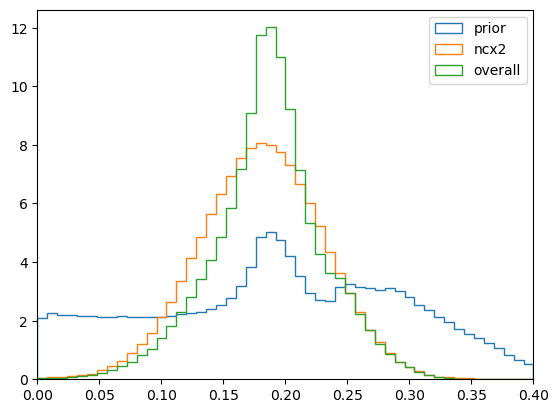

In [106]:
plt.hist(match_prior[match_prior<=0.4], histtype='step', bins=50, density=True, range=(0,0.4), label='prior')
plt.hist(ncx2_samples[ncx2_samples<=0.4], histtype='step', bins=50, density=True, range=(0,0.4), label='ncx2')
plt.hist(match_samples[match_samples<=0.4], histtype='step', bins=50, density=True, range=(0,0.4), label='overall')
plt.xlim(0, 0.4)
plt.legend()

8 loops


(0.0, 0.4)

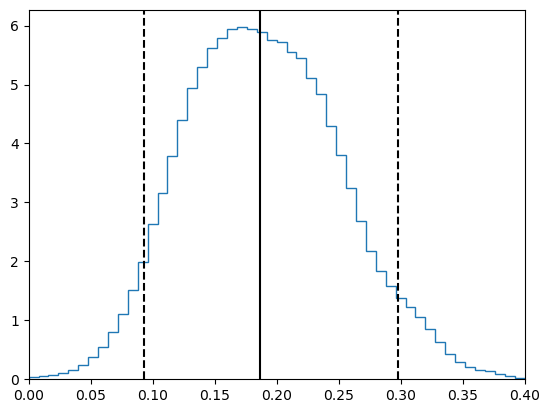

In [107]:
ecc_samples = SNR2ecc_rej(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples[ecc_samples<=0.4], histtype='step', bins=50, density=True, range=(0,0.4))
quantiles = np.quantile(ecc_samples, [0.05, 0.5, 0.95])
plt.axvline(quantiles[0], c='k', ls='dashed')
plt.axvline(quantiles[1], c='k', ls='solid')
plt.axvline(quantiles[2], c='k', ls='dashed')
plt.xlim(0, 0.4)

This has all worked very well. The eccentricity distribution above now has a nice smooth (and not bimodal) structure!

Finally let's make a quick plot comparing with and without enforcing a flat eccentricity prior.

7 loops


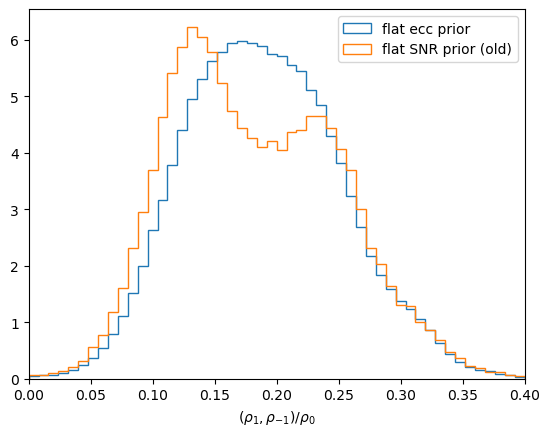

In [112]:
ecc_samples_old = SNR2ecc_rej(ncx2_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples, histtype='step', bins=50, density=True, range=(0,0.4), label='flat ecc prior')
plt.hist(ecc_samples_old, histtype='step', bins=50, density=True, range=(0,0.4), label='flat SNR prior (old)')
plt.xlim(0, 0.4)
plt.xlabel(r'$(\rho_{1}, \rho_{-1}) / \rho_{0}$')
plt.legend()
plt.savefig('Figures/ecc_dist_compare.png', dpi=450)